# How to work with the Copernicus DEM data on Earth Data Hub

The Copernicus DEM is a Digital Surface Model (DSM) representing the surface of the Earth and includes buildings, infrastructure and vegetation.


Earth Data Hub (EDH) provides an innovative access to earth related data. This notebook will provide you guidance on how to access and use the https://data.earthdatahub.destine.eu/copernicus-dem/GLO-30-v0.zarr dataset on Earth Data Hub.

In order to access datasets on Earth Data Hub you need to instruct your tools (xarray, Zarr, etc.) to use EDH personal access token when downloading the data.

To obtain a personal access token you first need to register to the Destination Earth platform. Then you can go to Earth Data Hub account settings where you can find your default personal access token or create others. After retrieving your personal access token, please cut and paste it below: ⤵

***
### What you will learn:
* how to access and preview the dataset
* select and average the data
* plot the results
***

Our first goal is *****

# Working with EDH data
Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment.

The structure of a workflow that uses EDH data tipically looks like this:

1. data access and preview
2. data selection
3. (optional) data download
4. (optional) data reduction
5. further operations and visualization

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

# 1. Data access and preview

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically when you access a Zarr dataset:

# 2. Data reduction

First, we perform a geographical selection corresponding to the Italy area:

# 3. Visualization

Finally, we can visualize the height above geoid of the Italy area.

In [1]:
import xarray as xr

ds = xr.open_dataset(
    "https://hedp-data.bopen.eu/public/derived-GPWv4-Histsoc/demographics-hybrid-1950-2020-15-min-v0",
    chunks={},
    engine="zarr",
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:               (age_band_lower_bound: 14, latitude: 720,
                           longitude: 1440, year: 71)
Coordinates:
  * age_band_lower_bound  (age_band_lower_bound) int64 112B 0 5 10 ... 55 60 65
  * latitude              (latitude) float64 6kB 90.0 89.75 ... -89.5 -89.75
  * longitude             (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * year                  (year) int64 568B 1950 1951 1952 ... 2018 2019 2020
Data variables:
    demographic_totals    (latitude, longitude, age_band_lower_bound, year) float32 4GB dask.array<chunksize=(64, 64, 14, 71), meta=np.ndarray>

In [2]:
df = ds.sel(year = 2000)

In [3]:
##QUESTE SONO PROVE MIE

##europe = df.sel(latitude=slice(70, 35), longitude=slice(0, 41))#[::1000, ::1000].compute()#dem.sel(lat=slice(35, 48), lon=slice(6, 19))[::100, ::100].compute()
##europe = df.sel(latitude=slice(70, 35), longitude=slice(0, 41))

##longi = xr.concat([df.isel(longitude=slice(0, 41)), df.isel(longitude=slice(350, 360))], dim="longitude")

#longi = df.where((df.longitude <= 41) | ((df.longitude <= 360) & (df.longitude >=350)), drop=True)

#longi = df.sel(longitude=(df.longitude < 41) | (df.longitude > 350))
#europe = longi.sel(latitude=slice(70, 35))

#europe = df
#europe

In [4]:
lon_name = 'longitude'  # whatever name is in the data

# Adjust lon values to make sure they are within (-180, 180)
df['_longitude_adjusted'] = xr.where(
    df[lon_name] > 180,
    df[lon_name] - 360,
    df[lon_name])

# reassign the new coords to as the main lon coords
# and sort DataArray using new coordinate values
ds_adjusted = (
    df
    .swap_dims({lon_name: '_longitude_adjusted'})
    .sel(**{'_longitude_adjusted': sorted(df._longitude_adjusted)})
    .drop_vars(lon_name))

ds_adjusted = ds_adjusted.rename({'_longitude_adjusted': lon_name})

In [5]:
ds_adjusted

<xarray.Dataset> Size: 58MB
Dimensions:               (age_band_lower_bound: 14, latitude: 720,
                           longitude: 1440)
Coordinates:
  * age_band_lower_bound  (age_band_lower_bound) int64 112B 0 5 10 ... 55 60 65
  * latitude              (latitude) float64 6kB 90.0 89.75 ... -89.5 -89.75
    year                  int64 8B 2000
  * longitude             (longitude) float64 12kB -179.8 -179.5 ... 179.8 180.0
Data variables:
    demographic_totals    (latitude, longitude, age_band_lower_bound) float32 58MB dask.array<chunksize=(64, 47, 14), meta=np.ndarray>

In [6]:
europe = ds_adjusted.sel(latitude=slice(70, 35), longitude=slice(-10,41))

In [7]:
europe_population = europe.sum("age_band_lower_bound")
europe_population

<xarray.Dataset> Size: 118kB
Dimensions:             (latitude: 141, longitude: 205)
Coordinates:
  * latitude            (latitude) float64 1kB 70.0 69.75 69.5 ... 35.25 35.0
    year                int64 8B 2000
  * longitude           (longitude) float64 2kB -10.0 -9.75 -9.5 ... 40.75 41.0
Data variables:
    demographic_totals  (latitude, longitude) float32 116kB dask.array<chunksize=(48, 8), meta=np.ndarray>

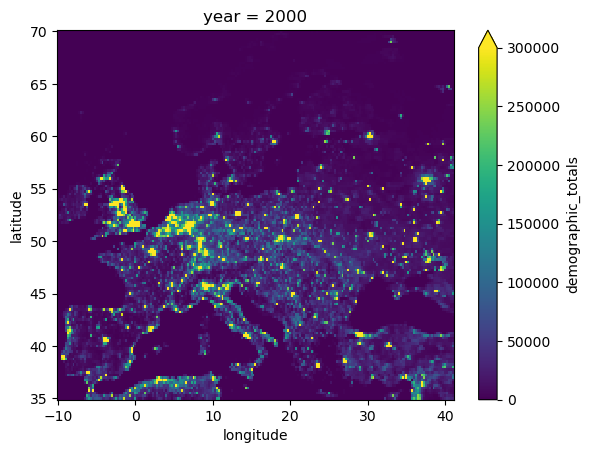

In [8]:
europe_population.demographic_totals.plot(vmax = 300_000)